In [1]:
import os
import numpy as np
import pandas as pd
import torch
import csv
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import DataLoader
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
from transformers import AutoModel, AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('ai4bharat/indic-bert')
model = AutoModel.from_pretrained('ai4bharat/indic-bert')

config.json:   0%|          | 0.00/507 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/5.65M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/135M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [3]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
print("Device : ", device) 

Device :  cuda


In [4]:
# project_path = "/content/drive/MyDrive/Colab/SRL/"
project_path = "/kaggle/input/output_dataset.csv"

In [5]:
!pip install conllu

In [6]:
# Specify the directory path
directory_path = '/kaggle/input/'

# List all files in the directory
files = os.listdir(directory_path)

# Print the list of files
print("Files in the directory:")
for file in files:
    print(file)

Files in the directory:
output_dataset.csv


In [7]:
sentences = []
srl_tags = []
csv_file = project_path
with open(csv_file, 'r', encoding='utf-8') as file:
    csv_reader = csv.reader(file)
    next(csv_reader)
    for row in csv_reader:
        sentence, srl = row
        words = sentence.split()
        srl_list = srl.split()
        sentences.append(words)
        srl_tags.append(srl_list)

In [8]:
# print(srl_tags)

In [9]:
# labels = ["ARG0","ARG1","ARG2","ARG3","ARG2-ATR","ARG2-LOC","ARG2-GOL","ARG2-SOU","ARGM-PRX","ARGM-ADV",
#         "ARGM-DIR","ARGM-EXT","ARGM-MNR","ARGM-PRP","ARGM-DIS","ARGM-LOC","ARGM-MNS","ARGM-NEG","ARGM-TMP",
#           "ARGM-CAU", "NO_SRL"]
A = set()
for arr in srl_tags:
    for tag in arr:
        A.add(tag)
labels = list(A)
label_dict = {label: index for index, label in enumerate(labels)}

In [10]:
# tokenized_sentences = [tokenizer.encode(sentence, add_special_tokens=True) for sentence in sentences[:10]]
x_t = tokenizer.encode(sentences[0][2], add_special_tokens = False)
print(x_t)

[1520]


In [11]:
tokenized_output = tokenizer(sentences[1][5], padding=True, return_attention_mask=True)
attention_mask = tokenized_output["attention_mask"]
print("Attention Mask:", attention_mask)
print(tokenized_output)

Attention Mask: [1, 1, 1, 1]
{'input_ids': [2, 100705, 339, 3], 'token_type_ids': [0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1]}


In [12]:
print(srl_tags[0][2])
print(sentences[0][2])
print(label_dict['NO_SRL'])
print(label_dict)

ARG2-ATR
मन
6
{'ARG2': 0, 'ARGM-MNS': 1, 'ARGM-EXT': 2, 'ARGM-DIS': 3, 'ARGM-MNR': 4, 'ARG0': 5, 'NO_SRL': 6, 'ARG2-SOU': 7, 'ARGM-ADV': 8, 'ARG2-ATR': 9, 'ARGM-CAU': 10, 'ARG3': 11, 'ARGM-DIR': 12, 'ARG-UNDEF': 13, 'ARGM-MOD': 14, 'ARG1': 15, 'ARG2-GOL': 16, 'ARGM-PRX': 17, 'ARGM-PRP': 18, 'ARGM-TMP': 19, 'ARGM-NEG': 20, 'ARG2-LOC': 21, 'ARGM-LOC': 22}


In [13]:
sentence_indices = []
label_indices = []
max_enc = 0
for i, sent in enumerate(sentences):
    s_t = [2]
    srl = [label_dict['NO_SRL']]
    for j, w in enumerate(sent):
        w_t = tokenizer.encode(w, add_special_tokens=False)
        max_enc = max(max_enc, len(w_t))
        s_t.extend(w_t)
        srl.extend([label_dict[srl_tags[i][j]]] * len(w_t))
    label_indices.append(srl)
    sentence_indices.append(s_t)

In [14]:
print(max_enc)
print(len(sentence_indices[1]))
print(len(label_indices[1]))

8
22
22


In [15]:
def pad(sentence_indices, label_indices):
    padded_sequences = []
    padded_labels = []
    attention_masks = []  # Attention masks list of lists
    max_length = max(len(sent) for sent in sentence_indices)
    for sent, label in zip(sentence_indices, label_indices):
        num_padding_tokens = max_length - len(sent)
        padded_sent = sent + [0] * num_padding_tokens
        padded_label = label + [label_dict['NO_SRL']] * num_padding_tokens
        attention_mask = [1] * len(sent) + [0] * num_padding_tokens
        padded_sequences.append(padded_sent)
        padded_labels.append(padded_label)
        attention_masks.append(attention_mask)
    return padded_sequences, padded_labels, attention_masks

In [16]:
pad_sentence_indices, pad_label_indices, masks = pad(sentence_indices, label_indices)

In [17]:
Xtrain = pad_sentence_indices[:-300]
train_masks = masks[:-300]
Ytrain = pad_label_indices[:-300]

Xtest = pad_sentence_indices[-300:]
test_masks = masks[-300:]
Ytest = pad_label_indices[-300:]

In [18]:
print(type(Xtrain))

<class 'list'>


---
---

<br>


In [19]:
def getEmbedding(sentence, mask):
    attention_mask = torch.tensor([mask])
    input_tensor = torch.tensor([sentence])
    with torch.no_grad():
        outputs = model(input_tensor, attention_mask = attention_mask)
    lhs = outputs.last_hidden_state
    embeddings = lhs[0]
    return embeddings

In [20]:
e1 = getEmbedding(pad_sentence_indices[1], masks[1])
print(e1.shape)
print(e1)

torch.Size([76, 768])
tensor([[-1.3179e-02, -4.9056e-04, -2.3103e-02,  ..., -1.2712e-02,
         -8.7744e-03, -1.3692e-02],
        [ 4.9362e-01, -3.4873e-01,  4.0460e-01,  ...,  3.8436e-01,
         -7.1830e-02,  1.4548e-01],
        [ 6.5916e-02, -3.1619e-01,  1.0254e-01,  ..., -1.2880e-01,
          3.9982e-01,  2.6452e-01],
        ...,
        [-1.0203e-01,  2.0529e-02,  1.1123e-01,  ..., -1.4480e-02,
         -9.9075e-03,  3.7889e-02],
        [-7.8551e-02,  8.5234e-03,  9.4996e-02,  ..., -1.3282e-02,
         -5.8353e-03,  4.1889e-02],
        [-1.8413e-02, -1.6006e-02,  3.0216e-02,  ..., -2.4423e-03,
         -1.0627e-02,  3.0827e-02]])


In [21]:
class SRLClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SRLClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        # First linear layer
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # Activation function (ReLU)
        self.relu = nn.ReLU()
        # Second linear layer
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Forward pass through the first linear layer
        out = self.fc1(x)
        # Apply activation function (ReLU)
        out = self.relu(out)
        # Forward pass through the second linear layer
        out = self.fc2(out)
        return out


In [22]:
input_dim = 768
hidden_dim = 32
output_dim = len(label_dict)
srl_classifier = SRLClassifier(input_dim, hidden_dim, output_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(srl_classifier.parameters(), lr = 0.001)

In [23]:
# batch_size = 32
# train_dataset = [(getEmbedding(sent), label) for sent, label in zip(Xtrain[:100], Ytrain[:100])]
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [24]:
def trainClassifier(classifier, Xtrain, Ytrain, n_epochs, optimizer):
    epoch_losses = []
    for epoch in range(n_epochs):
        classifier.train()
        running_loss = 0.0
        with tqdm(total=len(Xtrain), desc=f"Epoch {epoch+1}/{n_epochs}") as pbar:
            i = 0
            for sent, labels in zip(Xtrain, Ytrain):
                optimizer.zero_grad()
                encoded_sent = getEmbedding(sent, mask=train_masks[i])
                encoded_sent = encoded_sent.to(device)
                targets = torch.tensor(labels).to(device)
                outputs = classifier(encoded_sent).to(device)
                reshaped_outputs = outputs.view(-1, outputs.size(-1))
                reshaped_targets = targets.view(-1)
                loss = criterion(reshaped_outputs, reshaped_targets)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                pbar.update(1)
                i += 1
        epoch_loss = running_loss / len(Xtrain)
        epoch_losses.append(epoch_loss)
        print(f"Epoch {epoch+1}, Loss: {epoch_loss}\n")
    return epoch_losses


In [25]:
Epochs = 10
losses = trainClassifier(srl_classifier, Xtrain, Ytrain, Epochs, optimizer)

Epoch 1/10: 100%|██████████| 1007/1007 [02:01<00:00,  8.28it/s]


Epoch 1, Loss: 0.533179881630138



Epoch 2/10: 100%|██████████| 1007/1007 [02:00<00:00,  8.32it/s]


Epoch 2, Loss: 0.38423253050168316



Epoch 3/10: 100%|██████████| 1007/1007 [02:00<00:00,  8.35it/s]


Epoch 3, Loss: 0.36901694923905654



Epoch 4/10: 100%|██████████| 1007/1007 [01:59<00:00,  8.45it/s]


Epoch 4, Loss: 0.35797131889108513



Epoch 5/10: 100%|██████████| 1007/1007 [01:58<00:00,  8.46it/s]


Epoch 5, Loss: 0.3489226015745232



Epoch 6/10: 100%|██████████| 1007/1007 [01:58<00:00,  8.47it/s]


Epoch 6, Loss: 0.341009599203845



Epoch 7/10: 100%|██████████| 1007/1007 [01:58<00:00,  8.50it/s]


Epoch 7, Loss: 0.3339109617214217



Epoch 8/10: 100%|██████████| 1007/1007 [01:58<00:00,  8.49it/s]


Epoch 8, Loss: 0.3275007733533227



Epoch 9/10: 100%|██████████| 1007/1007 [01:59<00:00,  8.45it/s]


Epoch 9, Loss: 0.3216015697561404



Epoch 10/10: 100%|██████████| 1007/1007 [01:57<00:00,  8.55it/s]

Epoch 10, Loss: 0.31631902244789184



In [26]:
# print(Xtrain)
# print(Ytrain)

In [27]:
def saveModel(model, path):
    torch.save(model.state_dict(), path)

def loadModel(model, path):
    if device == 'cuda':
        model.load_state_dict(torch.load(path))
    else:
        model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))

In [28]:
working_path = "/kaggle/working/"
saveModel(srl_classifier, working_path + "classifier2.pt")

In [29]:
xt = getEmbedding(Xtrain[0], train_masks[0])
yt = torch.tensor(Ytrain[0])

In [30]:
# out = srl_classifier(xt.unsqueeze(0))

In [31]:
def evaluate(classifier, Xtest, Ytest):
    classifier.eval()
    total_samples = 0
    correct_samples = 0
    with torch.no_grad():
        for i, (sent, true_labels) in enumerate(zip(Xtest, Ytest)):
#             print(len(sent))
            encoded_sent = getEmbedding(sent, mask=test_masks[i])
            inputs = encoded_sent.unsqueeze(0).to(device)
            targets = torch.tensor(true_labels).to(device)
            outputs = classifier(inputs).to(device)
#             print(outputs.size())
            predicted_labels = outputs.max(dim=2)[1].view(-1)
            total_samples += len(true_labels)
#             print(predicted_labels.size())
#             print(targets.size())
            correct_samples += (predicted_labels == targets).sum().item()
    test_accuracy = correct_samples / total_samples
    return test_accuracy

In [32]:
a1 = evaluate(srl_classifier, Xtest, Ytest)

In [33]:
print(a1)

0.8987280701754385


In [34]:
print(losses)

[0.533179881630138, 0.38423253050168316, 0.36901694923905654, 0.35797131889108513, 0.3489226015745232, 0.341009599203845, 0.3339109617214217, 0.3275007733533227, 0.3216015697561404, 0.31631902244789184]


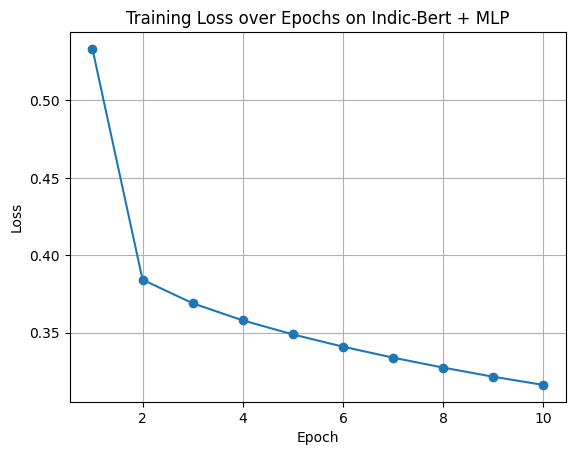

In [35]:
import matplotlib.pyplot as plt
# Plot the losses
plt.plot(range(1, len(losses) + 1), losses, marker='o', linestyle='-')
plt.title('Training Loss over Epochs on Indic-Bert + MLP')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [36]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate(classifier, Xtest, Ytest):
    classifier.eval()
    total_samples = 0
    correct_samples = 0
    predicted_labels_all = []
    true_labels_all = []
    
    with torch.no_grad():
        for i, (sent, true_labels) in enumerate(zip(Xtest, Ytest)):
            encoded_sent = getEmbedding(sent, mask=test_masks[i])
            inputs = encoded_sent.unsqueeze(0).to(device)
            targets = torch.tensor(true_labels).to(device)
            outputs = classifier(inputs).to(device)
            predicted_labels = outputs.max(dim=2)[1].view(-1)
            total_samples += len(true_labels)
            correct_samples += (predicted_labels == targets).sum().item()
            predicted_labels_all.extend(predicted_labels.cpu().numpy())
            true_labels_all.extend(targets.cpu().numpy())
    
    # Accuracy
    accuracy = accuracy_score(true_labels_all, predicted_labels_all)
    
    # Precision, Recall, F1 Score
    precision = precision_score(true_labels_all, predicted_labels_all, average='weighted')
    recall = recall_score(true_labels_all, predicted_labels_all, average='weighted')
    f1 = f1_score(true_labels_all, predicted_labels_all, average='weighted')
    
    return accuracy, precision, recall, f1


In [37]:
accuracy, precision, recall, f1 = evaluate(srl_classifier, Xtest, Ytest)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.8987280701754385
Precision: 0.8523548649691964
Recall: 0.8987280701754385
F1 Score: 0.8680929219116568
